In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.datasets import load_iris
from imblearn.over_sampling import ADASYN as ImblearnADASYN
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split

In [2]:
X, y = load_iris(return_X_y=True)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [23]:
class ADASYN:
    def __init__(self, k_neighbors=3, beta=1.0):
        self.k_neighbors = k_neighbors
        self.beta = beta

    def fit_resample(self, X, y):
        classes, class_counts = np.unique(y, return_counts=True)
        majority_class = classes[np.argmax(class_counts)]
        minority_class = classes[np.argmin(class_counts)]

        minority_samples = X[y == minority_class]
        majority_samples = X[y == majority_class]

        n_minority_samples = minority_samples.shape[0]
        n_majority_samples = majority_samples.shape[0]

        if n_minority_samples >= n_majority_samples:
            return X, y

        nn = NearestNeighbors(n_neighbors=self.k_neighbors).fit(X)
        neighbors = nn.kneighbors(minority_samples, return_distance=False)
    
        G = n_majority_samples - n_minority_samples
        r = np.zeros(n_minority_samples)
    
        for i in range(n_minority_samples):
            majority_neighbors = sum(y[neighbors[i][1:]] == majority_class)
            r[i] = majority_neighbors / self.k_neighbors

        r /= r.sum()

        synthetic_samples = []
        for i in range(n_minority_samples):
            n_synthetic_i = int(r[i] * G)
            for _ in range(n_synthetic_i):
                neighbor_idx = np.random.choice(neighbors[i][1:])
                neighbor = X[neighbor_idx]

                diff = neighbor - minority_samples[i]
                gap = np.random.rand()
                synthetic_sample = minority_samples[i] + gap * diff
                synthetic_samples.append(synthetic_sample)

        synthetic_samples = np.array(synthetic_samples)

        X_resampled = np.vstack((X, synthetic_samples))
        y_resampled = np.hstack((y, np.full(synthetic_samples.shape[0], minority_class)))
        return X_resampled, y_resampled

In [24]:
adasyn = ADASYN(k_neighbors=3)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

In [25]:
print("y_train:", Counter(y_train))
print("y_train_smote:", Counter(y_train_resampled))

y_train: Counter({2: 44, 0: 42, 1: 41})
y_train_smote: Counter({2: 44, 1: 44, 0: 42})


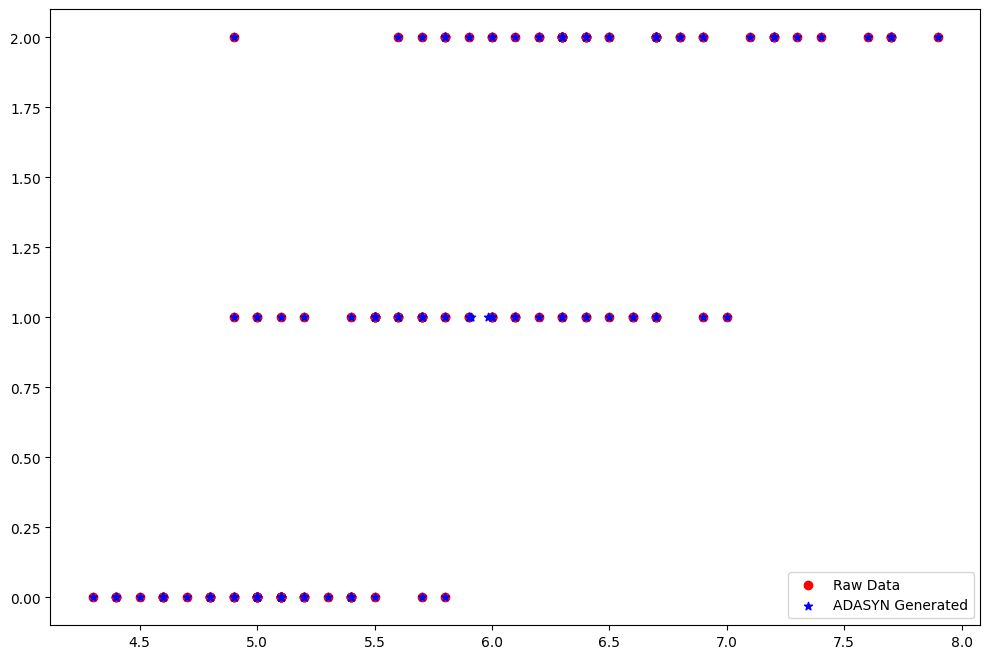

In [27]:
plt.figure(figsize=(12, 8))
plt.scatter(X_train[:, 0], y_train, color="r", marker="o")
plt.scatter(X_train_resampled[:, 0], y_train_resampled, color="b", marker="*")
plt.legend(["Raw Data", "ADASYN Generated"])
plt.show()